In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
path = os.path.join('..','raw_data','catalog.csv')
df = pd.read_csv(path, encoding= 'unicode_escape') # take care of non-ASCII characters such as 'ö'

df.head(3)

,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,URL,FORM,TYPE,SCHOOL,TIMEFRAME
0,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)",Venus and Adonis,1574-88,"Oil on canvas, 68 x 95 cm","Fogg Art Museum, Harvard University, Cambridge",https://www.wga.hu/html/a/aachen/adonis.html,painting,mythological,German,1601-1650
1,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)",Allegory,1598,"Oil on copper, 56 x 47 cm","Alte Pinakothek, Munich",https://www.wga.hu/html/a/aachen/allegory.html,painting,mythological,German,1601-1650
2,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)","Allegory of Peace, Art and Abundance",1602,"Oil on canvas, 197 x 142 cm","The Hermitage, St. Petersburg",https://www.wga.hu/html/a/aachen/allegorz.html,painting,mythological,German,1601-1650


In [3]:
def get_jpg_link(html_link: str) -> str:
    """Tranform the html_link of the image to its respective jpg_link"""
    
    jpg_link = html_link.replace('html','art', 1).replace('html','jpg')
    
    return jpg_link

html_link_test = 'https://www.wga.hu/html/a/aachen/adonis.html'
get_jpg_link(html_link_test) # should return 'https://www.wga.hu/art/a/aachen/adonis.jpg'

'https://www.wga.hu/art/a/aachen/adonis.jpg'

<class 'numpy.ndarray'> (900, 1235, 3)


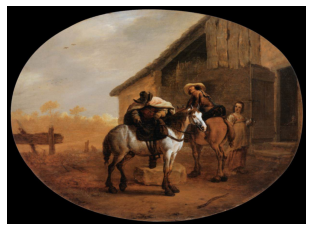

In [4]:
def jpg_to_array(jpg_link: str) -> np.ndarray:
    """Given an image jpg_link, it returns its vectorial representation"""
    
    img_vector = plt.imread(jpg_link, format='jpg')
    
    return img_vector

random_img_html = df.iloc[np.random.randint(0,len(df))]['URL']
random_img_jpg = get_jpg_link(random_img_html)
random_img_arr = jpg_to_array(random_img_jpg)

print(type(random_img_arr), random_img_arr.shape)

plt.imshow(random_img_arr)
plt.axis('off')
plt.show()

In [5]:
df_paintings = df.copy()
df_paintings = df_paintings[df_paintings['FORM'] == 'painting']
df_paintings.shape

(32008, 11)

In [11]:
test = df_paintings.iloc[:2]
test

,AUTHOR,BORN-DIED,TITLE,DATE,TECHNIQUE,LOCATION,URL,FORM,TYPE,SCHOOL,TIMEFRAME
0,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)",Venus and Adonis,1574-88,"Oil on canvas, 68 x 95 cm","Fogg Art Museum, Harvard University, Cambridge",https://www.wga.hu/html/a/aachen/adonis.html,painting,mythological,German,1601-1650
1,"AACHEN, Hans von","(b. 1552, Köln, d. 1615, Praha)",Allegory,1598,"Oil on copper, 56 x 47 cm","Alte Pinakothek, Munich",https://www.wga.hu/html/a/aachen/allegory.html,painting,mythological,German,1601-1650


In [7]:
from sklearn.base import TransformerMixin, BaseEstimator

class ImageFromHtml(TransformerMixin, BaseEstimator):
    """Adds IMAGE column, with vector representation of the image"""
    def __init__(self, url_col='URL'):
        self.url_col = url_col
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """X is a df with url_col"""
        X_transformed = X.copy()
        X_transformed['IMAGE'] = X[self.url_col].map(get_jpg_link).map(jpg_to_array)
        return X_transformed

In [8]:
def resize_image(img,width=420,height=360):
    dim = (width, height)
    return cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

class ImageResizer(TransformerMixin, BaseEstimator):
    def __init__(self, dim=(420,360), interpolation=cv2.INTER_AREA):
        self.dim = dim
        self.interpolation = interpolation
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """X is a pd.DataFrame with IMAGE column having vector representation of the image"""
        X_transformed = X.copy()
        X_transformed['IMAGE'] = X['IMAGE'].map(resize_image)
        return X_transformed

In [12]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('html', ImageFromHtml()),
    ('resize', ImageResizer())
])

In [ ]:
pipe.fit_transform(test)